<a href="https://colab.research.google.com/github/codygunton/WSB-posts/blob/main/WSB_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# needed only to save and load
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow_text umap-learn[plot] hdbscan

In [ ]:
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.cluster import KMeans

import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub
import umap, umap.plot
import hdbscan
print(f"TF version: {tf.__version__}")

import tensorflow as tf
# tf.debugging.set_log_device_placement(True)
print("Devices:", *tf.config.list_physical_devices(), sep="\n")

TF version: 2.4.1
Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


# Set directories and get data

In [ ]:
BASE_DIR_STR = "/content/drive/My Drive/" #@param
BASE_DIR = Path(BASE_DIR_STR)
REPO_DIR = BASE_DIR/"WSB-posts"

processed_data_version = "sentences_2021-03-07_12:45:54" #@param ["sentences_2021-03-05_10:36:08", "sentences_2021-03-07_12:45:54"]
PROCESSED_DATA_DIR = (REPO_DIR
             /"data"
             /processed_data_version)
PROCESSED_DATA_PATH = (PROCESSED_DATA_DIR/"part*")
print(f"Processed data version is {processed_data_version}")

Processed data version is sentences_2021-03-07_12:45:54


In [ ]:
REPO_DIR_STR = str(REPO_DIR).replace(" ", "\ ")
! git clone https://github.com/codygunton/WSB-posts/ {REPO_DIR_STR}

fatal: destination path '/content/drive/My Drive/WSB-posts' already exists and is not an empty directory.


In [ ]:
ds = (
    tf.data.experimental.make_csv_dataset(
          str(PROCESSED_DATA_PATH),
          batch_size=32,
          field_delim="\t",
          # NOTE: should set num_epochs to 1 to avoid having to
          # repeatedly use .take() below
          num_epochs=1,
          shuffle=True,
          shuffle_seed=1,
          header=True,
          column_defaults=[tf.string, tf.int32, tf.string],
          use_quote_delim=False))

ds = ds.apply(tf.data.experimental.prefetch_to_device("/GPU:0"))

In [ ]:
%%capture
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder-cmlm/en-base/1")

# Attempt 1: no dimensionality reduction; all sentence lengths allowed.

Data version is sentences_2021-03-05_10:36:08 (no truncation).

In [ ]:
day, time = str(datetime.now()).split()
time = time.split(".")[0]
timestamp = "_".join([day, time])
print(f"Current timestamp is {timestamp}.")
NP_SINK_DIR = PROCESSED_DATA_DIR/timestamp
(NP_SINK_DIR).mkdir()
print(f"Made directory {str(NP_SINK_DIR)}.")

Current timestamp is 2021-03-06_16:49:05.
Made directory /content/drive/My Drive/WSB-posts/data/sentences_2021-03-05_10:36:08/2021-03-06_16:49:05.


In [ ]:
%%time
def embed(row):
  s = row['long_sent']
  x = encoder(preprocessor(s))
  x = x['pooled_output']
  # this is needed for flat_map, but I had trouble
  # making flat_map computation happen on GPU.
  # z = tf.data.Dataset.from_tensor_slices(z)
  return x

with tf.device("/GPU:0"):
  X = []
  for row in ds.take(10):
    X.append(embed(row))
  X = np.concatenate(X)
print(X.shape)

np.save(NP_SINK_DIR/f"USE_embeddings_{timestamp}", X)

(320, 768)
CPU times: user 1.9 s, sys: 334 ms, total: 2.23 s
Wall time: 3.48 s


In [ ]:
%%time
clusterer = hdbscan.HDBSCAN()
clusterer.fit(X)

CPU times: user 176 ms, sys: 0 ns, total: 176 ms
Wall time: 178 ms


In [ ]:
np.save(NP_SINK_DIR/f"HDBSCAN_labels_{timestamp}", 
        clusterer.labels_)
labels = pd.Series(clusterer.labels_)
print(labels.nunique())
print(labels.value_counts())

159
-1      30183
 101       79
 121       48
 73        46
 135       33
        ...  
 71         5
 87         5
 8          5
 61         5
 0          5
Length: 159, dtype: int64


In [ ]:
%%time
from sklearn.cluster import KMeans
kmeans = KMeans()
kmeans.fit(X)

CPU times: user 50.6 s, sys: 7.2 s, total: 57.8 s
Wall time: 47.2 s


In [ ]:
%%time
clusterings = {}
for n in range(4, 20):
  kmeans = KMeans(n)
  kmeans.fit(X)
  clusterings[n] = kmeans.labels_

CPU times: user 17min 41s, sys: 3min 22s, total: 21min 4s
Wall time: 16min 9s


In [ ]:
%%time
silhouette_scores = []
db_scores = []
for n, labels in clusterings.items():
  score = metrics.silhouette_score(X, labels)
  silhouette_scores.append(score)
  score = metrics.davies_bouldin_score(X, labels)
  db_scores.append(score)

CPU times: user 23min 36s, sys: 1min 44s, total: 25min 20s
Wall time: 13min 49s


In [ ]:
# we want a large Silhouette score and a small DB score.
pd.DataFrame({"silhouette": silhouette_scores, 
              "db": db_scores},
             index=clusterings.keys())

,silhouette,db
4,0.030288,4.468779
5,0.028977,4.381662
6,0.030098,4.516611
7,0.028639,4.935747
8,0.028733,5.094397
9,0.022640,5.051596
10,0.019771,4.940589
11,0.019824,4.924549
12,0.020806,4.864833
13,0.021240,4.851623


In [ ]:
for n, labels in clusterings.items():
  labels.tofile(PROCESSED_DATA_PATH.parent/"k_means_labels"/f"{n}_means_{timestamp}.nparray")  

We see (very) weak support for 14 clusters.

In [ ]:
pd.Series(clusterings[14]).value_counts()

5     3915
1     3510
3     3499
8     2992
2     2584
13    2456
6     2368
10    1875
7     1810
11    1615
12    1449
0     1383
4     1344
9     1200
dtype: int64

# Attempt 2: do some dimensionality reduction 
Generate embeddings once and reuse.

Data version is sentences_2021-03-05_10:36:08 (no truncation).

Timestamp is 2021-03-06_17:01:11

In [ ]:
# day, time = str(datetime.now()).split()
# time = time.split(".")[0]
# timestamp = "_".join([day, time])
timestamp = "2021-03-06_17:01:11"
# print(f"Current timestamp is {timestamp}.")
NP_SINK_DIR = PROCESSED_DATA_DIR/timestamp
# (NP_SINK_DIR).mkdir()
# print(f"Made directory {str(NP_SINK_DIR)}.")

In [ ]:
# %%time
# def embed(row):
#   s = row['long_sent']
#   x = encoder(preprocessor(s))
#   x = x['pooled_output']
#   # this is needed for flat_map, but I had trouble
#   # making flat_map computation happen on GPU.
#   # z = tf.data.Dataset.from_tensor_slices(z)
#   return x

# with tf.device("/GPU:0"):
#   X = []
#   for row in ds.take(1000):
#     X.append(embed(row))
#   X = np.concatenate(X)
# print(X.shape)

USE_EMB_PATH = str(NP_SINK_DIR/f"USE_embeddings_{timestamp}")

# np.save(USE_EMB_PATH, X)

X = np.load(USE_EMB_PATH+".npy")
X.shape

FileNotFoundError: ignored

## HDBSCAN label distribution
Run last experiment again and look at how labels are distributed

In [ ]:
value_counts = {}

for n_components in range(2, 50, 2):
  print(f"Embedding dimension is {n_components}")

  print("Embedding...")
  reducer = umap.UMAP(n_components=n_components,
                      densmap=True)
  %time Z = reducer.fit_transform(X)

  UMAP_EMB_PATH = str(NP_SINK_DIR/"UMAP_embeddings_{timestamp}_dim={n}")
  np.save(UMAP_EMB_PATH.format(timestamp=timestamp, 
                              n=str(n_components).zfill(3)), 
          Z)
  

  print("Clustering...")
  clusterer = hdbscan.HDBSCAN()
  %time clusterer.fit(Z)

  HDBSCAN_LABEL_PATH = str(NP_SINK_DIR/"HDBSCAN_labels_{timestamp}_dim={n}")
  np.save(HDBSCAN_LABEL_PATH.format(timestamp=timestamp,
                                  n=str(n_components).zfill(3)), 
        clusterer.labels_)
  
  labels = pd.Series(clusterer.labels_)
  vcs = labels.value_counts()
  value_counts[n_components] = vcs
  print("\n\n----------------------\n\n")

Embedding dimension is 2
Embedding...
CPU times: user 2min 27s, sys: 721 ms, total: 2min 27s
Wall time: 1min 28s
Clustering...
CPU times: user 793 ms, sys: 168 ms, total: 961 ms
Wall time: 2.47 s


----------------------


Embedding dimension is 4
Embedding...
CPU times: user 2min 34s, sys: 860 ms, total: 2min 34s
Wall time: 1min 32s
Clustering...
CPU times: user 1.18 s, sys: 6.03 ms, total: 1.18 s
Wall time: 2.05 s


----------------------


Embedding dimension is 6
Embedding...
CPU times: user 2min 45s, sys: 715 ms, total: 2min 45s
Wall time: 1min 38s
Clustering...
CPU times: user 1.62 s, sys: 7.01 ms, total: 1.62 s
Wall time: 3.58 s


----------------------


Embedding dimension is 8
Embedding...
CPU times: user 2min 52s, sys: 1.05 s, total: 2min 53s
Wall time: 1min 41s
Clustering...
CPU times: user 1.87 s, sys: 3.05 ms, total: 1.87 s
Wall time: 4.26 s


----------------------


Embedding dimension is 10
Embedding...
CPU times: user 3min 1s, sys: 1.05 s, total: 3min 2s
Wall time: 1m

          0
-1    23744
 435    499
 297    230
 331    144
 411    139
 371    124
 95     103
 42      90
 358     86
 207     84
 444     81
 0       78
 107     77
 150     73
 145     70
 135     68
 283     64
 440     61
 221     61
 288     57
 285     52


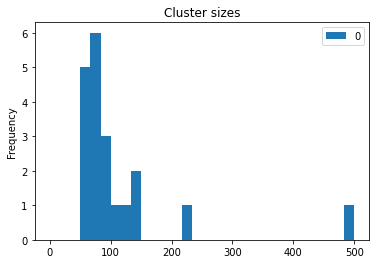

In [ ]:
vcs = value_counts[14]
print(vcs.head(21))
axes = vcs[1:21].plot(title="Cluster sizes",
                    kind="hist",
                    **{"bins":30, 
                       "range":(0,500)})

In [ ]:
for n, vcs in value_counts.items():
  print(f"Dimension: {n}")
  print(vcs.head(20))
  print("\n\n----------------------\n\n")

Dimension: 2
-1       14857
 324       168
 1010      120
 532       113
 1031      107
 466       101
 204       100
 39         77
 784        76
 506        75
 356        73
 663        72
 409        67
 244        63
 479        62
 735        61
 343        61
 810        58
 848        58
 491        58
dtype: int64


----------------------


Dimension: 4
-1      22538
 316      633
 393      515
 163      273
 329      213
 275      179
 366      112
 10        98
 41        98
 112       96
 229       96
 278       95
 386       79
 219       78
 2         76
 258       73
 209       73
 352       69
 200       65
 239       63
dtype: int64


----------------------


Dimension: 6
-1      23591
 457      479
 223      222
 346      152
 417      121
 68       113
 200      104
 221       97
 337       95
 35        87
 2         78
 191       74
 463       74
 160       73
 453       73
 129       69
 432       68
 168       64
 206       63
 210       61
dtype: int64


------

## k-Means experiment 01

Grid search on UMAP embedding dimension and k, then compute and investigate internal validation metrics.

Note: have nested directories in NP_SINK_DIR since running cells.

In [ ]:
value_counts = {}

for n_components in range(2, 50, 2):
  print(f"Embedding dimension is {n_components}")

  print("Embedding...")
  # reducer = umap.UMAP(n_components=n_components,
  #                     densmap=True)
  # %time Z = reducer.fit_transform(X)

  UMAP_EMB_PATH = str(NP_SINK_DIR/"UMAP_embeddings_{timestamp}_dim={n}.npy")
  Z = np.load(UMAP_EMB_PATH.format(timestamp=timestamp, 
                              n=str(n_components).zfill(3)))
  

  print("Clustering...")
  def do_clustering():
    for k in range(2,50,2):
      clusterer = KMeans(k)
      clusterer.fit(Z)

      KMEANS_LABEL_PATH = str(NP_SINK_DIR/"KMEANS_labels_{timestamp}_dim={n}_k={k}")
      np.save(KMEANS_LABEL_PATH.format(timestamp=timestamp,
                                      n=str(n_components).zfill(3),
                                      k=k),
              clusterer.labels_)
    
      labels = pd.Series(clusterer.labels_)
      vcs = labels.value_counts()
      value_counts[(n_components, k)] = vcs
  %time do_clustering()
  print("\n\n----------------------\n\n")

Embedding dimension is 2
Embedding...
Clustering...
CPU times: user 1min 13s, sys: 758 ms, total: 1min 13s
Wall time: 1min 13s


----------------------


Embedding dimension is 4
Embedding...
Clustering...
CPU times: user 1min 47s, sys: 944 ms, total: 1min 48s
Wall time: 1min 48s


----------------------


Embedding dimension is 6
Embedding...
Clustering...
CPU times: user 1min 50s, sys: 978 ms, total: 1min 51s
Wall time: 1min 51s


----------------------


Embedding dimension is 8
Embedding...
Clustering...
CPU times: user 2min, sys: 1.03 s, total: 2min 1s
Wall time: 2min 1s


----------------------


Embedding dimension is 10
Embedding...
Clustering...
CPU times: user 2min 14s, sys: 25.5 s, total: 2min 39s
Wall time: 2min 12s


----------------------


Embedding dimension is 12
Embedding...
Clustering...
CPU times: user 2min 21s, sys: 25.8 s, total: 2min 47s
Wall time: 2min 20s


----------------------


Embedding dimension is 14
Embedding...
Clustering...
CPU times: user 2min 20s, s

In [ ]:
for (n, k), vcs in value_counts.items():
  if n < 14:
    print(f"Dimension: {n}, K: {k}")
    print(vcs.head(20))
    print("\n\n----------------------\n\n")

Dimension: 2, K: 2
1    20638
0    11362
dtype: int64


----------------------


Dimension: 2, K: 4
1    8936
3    8281
2    8119
0    6664
dtype: int64


----------------------


Dimension: 2, K: 6
1    7151
3    6501
4    5455
5    4673
2    4593
0    3627
dtype: int64


----------------------


Dimension: 2, K: 8
0    6252
6    5425
4    4713
1    4490
5    3308
2    2860
3    2673
7    2279
dtype: int64


----------------------


Dimension: 2, K: 10
6    5256
0    4899
4    3838
3    3124
5    3094
2    3042
7    2822
8    2119
1    1952
9    1854
dtype: int64


----------------------


Dimension: 2, K: 12
4     4375
2     3821
3     3742
5     2962
6     2889
11    2726
9     2184
7     2118
1     1945
10    1868
8     1763
0     1607
dtype: int64


----------------------


Dimension: 2, K: 14
7     3775
4     3623
1     3384
5     2886
11    2682
6     2398
0     2335
2     2046
3     1904
9     1660
10    1606
13    1454
8     1430
12     817
dtype: int64


---------------------

In [ ]:
%%time
silhouette_scores = {}
db_scores = {}
for d in range(2, 30, 2):
  UMAP_EMB_PATH = str(NP_SINK_DIR/
                      "UMAP_embeddings_{timestamp}_dim={n}.npy")
  Z = np.load(UMAP_EMB_PATH.format(timestamp=timestamp, 
                              n=str(d).zfill(3)))
  for k in range(4, 20, 2):
    print(f"(d, k) = {(d,k)}")
    KMEANS_LABEL_PATH = str(NP_SINK_DIR/
                            "KMEANS_labels_{timestamp}_dim={n}_k={k}.npy")
    labels = np.load(KMEANS_LABEL_PATH.format(timestamp=timestamp,
                                    n=str(d).zfill(3),
                                    k=k))

    print("Computing Silhouette score")
    score = metrics.silhouette_score(Z, labels)
    silhouette_scores[(d,k)] = score
    print("Computing Davies-Bouldin score")
    score = metrics.davies_bouldin_score(Z, labels)
    db_scores[(d,k)] = score
    print("\n")

(d, k) = (2, 4)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (2, 6)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (2, 8)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (2, 10)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (2, 12)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (2, 14)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (2, 16)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (2, 18)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (4, 4)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (4, 6)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (4, 8)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (4, 10)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (4, 12)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k

In [ ]:
scores = pd.DataFrame({"silhouette":silhouette_scores,
                       "db":db_scores})
scores.to_json(str(NP_SINK_DIR/"kmeans_scores.json"))

In [ ]:
scores

silhouette        db
2  4     0.372587  0.873290
   6     0.362377  0.876167
   8     0.377609  0.821260
   10    0.374408  0.793733
   12    0.363154  0.853097
...           ...       ...
28 10    0.237411  1.406453
   12    0.239927  1.317928
   14    0.241375  1.306999
   16    0.232892  1.298479
   18    0.237374  1.296709

[112 rows x 2 columns]

In [ ]:
# test restoring
scores = pd.read_json(str(NP_SINK_DIR/"kmeans_scores.json"))
# eval is harmless at the moment.
index = [eval(s) for s in scores.index]
index = pd.MultiIndex.from_tuples(index)
scores = scores.set_index(index)
scores

silhouette        db
2  2     0.420928  0.929332
   4     0.286397  1.189029
   6     0.262092  1.336504
   8     0.229772  1.409293
   10    0.243599  1.344702
...           ...       ...
10 40    0.209154  1.291694
   42    0.205936  1.310268
   44    0.203538  1.285213
   46    0.203341  1.333627
   48    0.207120  1.318387

[120 rows x 2 columns]

In [ ]:
pd.set_option("display.max_rows", scores.shape[0]+1)
print(scores)

       silhouette        db
2  4     0.372587  0.873290
   6     0.362377  0.876167
   8     0.377609  0.821260
   10    0.374408  0.793733
   12    0.363154  0.853097
   14    0.361988  0.831234
   16    0.355400  0.834685
   18    0.346967  0.845895
4  4     0.302817  1.140888
   6     0.290670  1.184171
   8     0.278511  1.178782
   10    0.262825  1.270291
   12    0.263429  1.211949
   14    0.266840  1.187485
   16    0.267767  1.152716
   18    0.255776  1.168621
6  4     0.291696  1.175942
   6     0.271135  1.297091
   8     0.240565  1.365593
   10    0.244005  1.331715
   12    0.246847  1.281962
   14    0.241820  1.253708
   16    0.248464  1.251700
   18    0.249880  1.273182
8  4     0.289682  1.192670
   6     0.266951  1.327858
   8     0.238015  1.393892
   10    0.243023  1.360898
   12    0.243594  1.330017
   14    0.249902  1.233025
   16    0.249657  1.223117
   18    0.248438  1.287900
10 4     0.290024  1.195534
   6     0.265601  1.334677
   8     0.236063  1

In [ ]:
# we want a large Silhouette score and a small DB score.
pd.DataFrame({"silhouette": silhouette_scores, 
              "db": db_scores},
             index=clusterings.keys())

,silhouette,db
4,0.030288,4.468779
5,0.028977,4.381662
6,0.030098,4.516611
7,0.028639,4.935747
8,0.028733,5.094397
9,0.022640,5.051596
10,0.019771,4.940589
11,0.019824,4.924549
12,0.020806,4.864833
13,0.021240,4.851623


## HDBSCAN experiment 01
Grid search on UMAP embedding dimension and min cluster size.

In [ ]:
value_counts = {}
labels_dict = {}
for d in range(12, 32, 2):
  UMAP_EMB_PATH = str(NP_SINK_DIR/
                      "UMAP_embeddings_{timestamp}_dim={n}.npy")
  Z = np.load(UMAP_EMB_PATH.format(timestamp=timestamp, 
                              n=str(d).zfill(3)))

  Z = Z[:2000]

  for m in range(20, 100, 5):
    print(f"(d,m) = {(d,m)}")
    print("Clustering...")
    clusterer = hdbscan.HDBSCAN(min_cluster_size=m)
    %time clusterer.fit(Z)


    HDBSCAN_LABEL_PATH = str(NP_SINK_DIR/
                            "HDBSCAN_labels_{timestamp}_dim={d}_min_cl_size={m}")
    np.save(HDBSCAN_LABEL_PATH.format(timestamp=timestamp,
                                      d=str(d).zfill(3),
                                      m=str(m).zfill(3)),
          clusterer.labels_)
    
    labels = pd.Series(clusterer.labels_)
    labels_dict[(d,m)] = labels
    vcs = labels.value_counts()
    value_counts[(d,m)] = vcs
    print(f"Number of labels: {len(vcs.index)}")
    print("\n----------------------\n\n")

(d,m) = (12, 20)
Clustering...
CPU times: user 118 ms, sys: 945 µs, total: 119 ms
Wall time: 124 ms
(d,m) = (12, 25)
Clustering...
CPU times: user 117 ms, sys: 2.08 ms, total: 119 ms
Wall time: 121 ms
(d,m) = (12, 30)
Clustering...
CPU times: user 121 ms, sys: 0 ns, total: 121 ms
Wall time: 122 ms
(d,m) = (12, 35)
Clustering...
CPU times: user 118 ms, sys: 0 ns, total: 118 ms
Wall time: 118 ms
(d,m) = (12, 40)
Clustering...
CPU times: user 124 ms, sys: 972 µs, total: 125 ms
Wall time: 127 ms
(d,m) = (12, 45)
Clustering...
CPU times: user 127 ms, sys: 951 µs, total: 128 ms
Wall time: 128 ms
(d,m) = (12, 50)
Clustering...
CPU times: user 128 ms, sys: 0 ns, total: 128 ms
Wall time: 129 ms
(d,m) = (12, 55)
Clustering...
CPU times: user 129 ms, sys: 1.94 ms, total: 131 ms
Wall time: 133 ms
(d,m) = (12, 60)
Clustering...
CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 133 ms
(d,m) = (12, 65)
Clustering...
CPU times: user 135 ms, sys: 0 ns, total: 135 ms
Wall time: 135 ms
(d,m) = 

In [ ]:
d = dict([((d,m), S.value_counts().shape[0]) for (d, m), S in labels_dict.items()])
cluster_counts = pd.DataFrame({"num_clusters":d})
cluster_counts.to_json(str(NP_SINK_DIR/"HDBSCAN_cluster_counts.json"))

num_clusters
12 20             6
   25             4
   30             3
   35             3
   40             5
...             ...
30 75             3
   80             1
   85             1
   90             1
   95             1

[160 rows x 1 columns]

Had these prelim results on small sample
(d, m), num_clusters

((12, 5), 3)
((12, 10), 3)
((12, 15), 3)
((12, 20), 1)
((14, 5), 3)
((14, 10), 3)
((14, 15), 3)
((14, 20), 1)
((16, 5), 3)
((16, 10), 3)
((16, 15), 3)
((16, 20), 1)
((18, 5), 5)
((18, 10), 3)
((18, 15), 3)
((18, 20), 1)
((20, 5), 3)
((20, 10), 3)
((20, 15), 3)
((20, 20), 1)


Had a bug (multiplication by 50) that gave constant value 1 as in 
```
  for m in range(20, 100, 5):
    print(f"(d,m) = {(d,m)}")
    print("Clustering...")
    clusterer = hdbscan.HDBSCAN(min_cluster_size=50*m)
```
Takeaway: min cluster size $\geq$ 2000 is too large



## HDBSCAN experiment 02
Grid search on UMAP embedding dimension and min cluster size.

In [ ]:
value_counts = {}
labels_dict = {}
for d in range(2, 30, 2):
  UMAP_EMB_PATH = str(NP_SINK_DIR/"UMAP_embeddings_01"/
                      "UMAP_embeddings_{timestamp}_dim={n}.npy")
  Z = np.load(UMAP_EMB_PATH.format(timestamp=timestamp, 
                              n=str(d).zfill(3)))
  # Z = Z[:25000]

  for m in range(5, 50, 5):
    print(f"(d,m) = {(d,m)}")
    print("Clustering...")
    clusterer = hdbscan.HDBSCAN(min_cluster_size=m)
    try:
      %time clusterer.fit(Z)


      HDBSCAN_LABEL_PATH = str(NP_SINK_DIR/"HDBSCAN_labels_02"/
                              "HDBSCAN_labels_{timestamp}_dim={d}_min_cl_size={m}")
      np.save(HDBSCAN_LABEL_PATH.format(timestamp=timestamp,
                                        d=str(d).zfill(3),
                                        m=str(m).zfill(3)),
            clusterer.labels_)
      
      labels = pd.Series(clusterer.labels_)
      labels_dict[(d,m)] = labels
      vcs = labels.value_counts()
      value_counts[(d,m)] = vcs
      print(f"Number of labels: {len(vcs.index)}")
      
    except Exception as e:
      value_counts[(d,m)] = -1
      print(f"Failed at (d,m)={(d,m)} with exception\n", e)

    print("\n----------------------\n\n")

d = dict([((d,m), S.value_counts().shape[0]) for (d, m), S in labels_dict.items()])
cluster_counts = pd.DataFrame({"num_clusters":d})
cluster_counts.to_json(str(NP_SINK_DIR/"HDBSCAN_cluster_counts_02.json"))    

(d,m) = (2, 5)
Clustering...
CPU times: user 1.14 s, sys: 50.1 ms, total: 1.19 s
Wall time: 2.98 s
Number of labels: 1196

----------------------


(d,m) = (2, 10)
Clustering...
CPU times: user 1.01 s, sys: 5.96 ms, total: 1.01 s
Wall time: 1.29 s
Number of labels: 369

----------------------


(d,m) = (2, 15)
Clustering...
CPU times: user 1.05 s, sys: 5.99 ms, total: 1.06 s
Wall time: 1.38 s
Number of labels: 5

----------------------


(d,m) = (2, 20)
Clustering...
CPU times: user 995 ms, sys: 6.01 ms, total: 1 s
Wall time: 1.35 s
Number of labels: 8

----------------------


(d,m) = (2, 25)
Clustering...
CPU times: user 1.01 s, sys: 8.73 ms, total: 1.02 s
Wall time: 1.41 s
Number of labels: 8

----------------------


(d,m) = (2, 30)
Clustering...
CPU times: user 1.01 s, sys: 14.6 ms, total: 1.03 s
Wall time: 1.46 s
Number of labels: 6

----------------------


(d,m) = (2, 35)
Clustering...
CPU times: user 1.03 s, sys: 5.01 ms, total: 1.03 s
Wall time: 1.49 s
Number of labels: 6

--

In [ ]:
pd.set_option("display.max_rows", cluster_counts.shape[0]+1)
cc = cluster_counts
cc

num_clusters
2  5           1196
   10           369
   15             5
   20             8
   25             8
   30             6
   35             6
   40             6
   45             6
4  5            490
   10           179
   15             4
   20             3
   25             3
   30             3
   35             3
   40             3
   45             3
6  5            470
   10           169
   15           117
   20            79
   25             3
   30             3
   35             3
   40             4
   45             4
8  5            455
   10           163
   15             4
   20             3
   25             3
   30             3
   35             3
   40             3
   45             3
10 5            466
   10             3
   15             3
   20             3
   25             3
   30             3
   35             3
   40             3
   45             3
12 5            463
   10             3
   15             3
   20             3
   25             3
   30             3
   35             3
   40             3
   45             4
14 5            450
   10           174
   15           114
   20            81
   25             3
   30             7
   35             3
   40             4
   45             4
16 5            442
   10             3
   15             3
   20             3
   25             3
   30             3
   35             3
   40             3
   45             3
18 5            439
   10           173
   15             3
   20             3
   25             3
   30             3
   35             3
   40             3
   45             3
20 5            460
   10           166
   15             3
   20             3
   25             3
   30             3
   35             3
   40             3
   45             3
22 5            448
   10             3
   15             3
   20             3
   25             3
   30             3
   35             3
   40             3
   45             3
24 5            444
   10             3
   15             3
   20             3
   25             3
   30             3
   35             3
   40             3
   45             3
26 5            459
   10           182
   15           112
   20             3
   25             3
   30             3
   35             3
   40             3
   45             3
28 5            454
   10           177
   15             3
   20             3
   25             3
   30             3
   35             3
   40             3
   45             3

In [ ]:
cc.query("4 < num_clusters < 20")

num_clusters
2  15             5
   20             8
   25             8
   30             6
   35             6
   40             6
   45             6
14 30             7

In [ ]:
HDBSCAN_LABEL_PATH = str(NP_SINK_DIR/"HDBSCAN_labels_02"/
                        "HDBSCAN_labels_{timestamp}_dim={d}_min_cl_size={m}.npy")
(d, m) = (14, 30)
l = np.load(HDBSCAN_LABEL_PATH.format(timestamp=timestamp,
                                      d=str(d).zfill(3),
                                      m=str(m).zfill(3)))
print(f"(d,m)={(d,m)}")
pd.Series(l).value_counts()

(d,m)=(14, 30)


 4    28841
-1     2867
 3       96
 0       78
 5       48
 2       37
 1       33
dtype: int64

In [ ]:
HDBSCAN_LABEL_PATH = str(NP_SINK_DIR/"HDBSCAN_labels_02"/
                        "HDBSCAN_labels_{timestamp}_dim={d}_min_cl_size={m}.npy")
(d, m) = (2, 30)
l = np.load(HDBSCAN_LABEL_PATH.format(timestamp=timestamp,
                                      d=str(d).zfill(3),
                                      m=str(m).zfill(3)))
print(f"(d,m)={(d,m)}")
pd.Series(l).value_counts()

(d,m)=(2, 30)


 4    30014
-1     1597
 1      166
 0       98
 2       82
 3       43
dtype: int64

In [ ]:
for n, labels in clusterings.items():
  labels.tofile(PROCESSED_DATA_PATH.parent/"k_means_labels"/f"{n}_means_{timestamp}.nparray")  

## HDBSCAN experiment 03
Grid search on UMAP embedding dimension and min cluster size. Trying smaller range of min cluster sizes.

In [ ]:
value_counts = {}
labels_dict = {}
for d in range(2, 12, 2):
  UMAP_EMB_PATH = str(NP_SINK_DIR/"UMAP_embeddings_01"/
                      "UMAP_embeddings_{timestamp}_dim={n}.npy")
  Z = np.load(UMAP_EMB_PATH.format(timestamp=timestamp, 
                              n=str(d).zfill(3)))
  # Z = Z[:25000]

  for m in range(5, 20):
    print(f"(d,m) = {(d,m)}")
    print("Clustering...")
    clusterer = hdbscan.HDBSCAN(min_cluster_size=m)
    try:
      %time clusterer.fit(Z)


      HDBSCAN_LABEL_PATH = str(NP_SINK_DIR/"HDBSCAN_labels_03"/
                              "HDBSCAN_labels_{timestamp}_dim={d}_min_cl_size={m}")
      np.save(HDBSCAN_LABEL_PATH.format(timestamp=timestamp,
                                        d=str(d).zfill(3),
                                        m=str(m).zfill(3)),
            clusterer.labels_)
      
      labels = pd.Series(clusterer.labels_)
      labels_dict[(d,m)] = labels
      vcs = labels.value_counts()
      value_counts[(d,m)] = vcs
      print(f"Number of labels: {len(vcs.index)}")
      
    except Exception as e:
      value_counts[(d,m)] = -1
      print(f"Failed at (d,m)={(d,m)} with exception\n", e)

    print("\n----------------------\n\n")

d = dict([((d,m), S.value_counts().shape[0]) for (d, m), S in labels_dict.items()])
cluster_counts = pd.DataFrame({"num_clusters":d})
cluster_counts.to_json(str(NP_SINK_DIR/"HDBSCAN_cluster_counts_03.json"))    

(d,m) = (2, 5)
Clustering...
CPU times: user 1.11 s, sys: 69.1 ms, total: 1.18 s
Wall time: 3.27 s
Number of labels: 1196

----------------------


(d,m) = (2, 6)
Clustering...
CPU times: user 1.06 s, sys: 6.02 ms, total: 1.06 s
Wall time: 1.31 s
Number of labels: 878

----------------------


(d,m) = (2, 7)
Clustering...
CPU times: user 1.04 s, sys: 13 ms, total: 1.05 s
Wall time: 1.31 s
Number of labels: 701

----------------------


(d,m) = (2, 8)
Clustering...
CPU times: user 1.02 s, sys: 10 ms, total: 1.03 s
Wall time: 1.29 s
Number of labels: 574

----------------------


(d,m) = (2, 9)
Clustering...
CPU times: user 1.04 s, sys: 10.1 ms, total: 1.05 s
Wall time: 1.32 s
Number of labels: 483

----------------------


(d,m) = (2, 10)
Clustering...
CPU times: user 1.01 s, sys: 8.01 ms, total: 1.02 s
Wall time: 1.3 s
Number of labels: 369

----------------------


(d,m) = (2, 11)
Clustering...
CPU times: user 1.02 s, sys: 8.01 ms, total: 1.03 s
Wall time: 1.34 s
Number of labels: 310

In [ ]:
pd.set_option("display.max_rows", cluster_counts.shape[0]+1)
cc = cluster_counts
cc.query("4 < num_clusters < 20")

num_clusters
2 15             5
  16             5
  18            11
  19            11

In [ ]:
HDBSCAN_LABEL_PATH = str(NP_SINK_DIR/"HDBSCAN_labels_02"/
                        "HDBSCAN_labels_{timestamp}_dim={d}_min_cl_size={m}.npy")
(d, m) = (14, 30)
l = np.load(HDBSCAN_LABEL_PATH.format(timestamp=timestamp,
                                      d=str(d).zfill(3),
                                      m=str(m).zfill(3)))
print(f"(d,m)={(d,m)}")
pd.Series(l).value_counts()

(d,m)=(14, 30)


 4    28841
-1     2867
 3       96
 0       78
 5       48
 2       37
 1       33
dtype: int64

In [ ]:
HDBSCAN_LABEL_PATH = str(NP_SINK_DIR/"HDBSCAN_labels_02"/
                        "HDBSCAN_labels_{timestamp}_dim={d}_min_cl_size={m}.npy")
(d, m) = (2, 30)
l = np.load(HDBSCAN_LABEL_PATH.format(timestamp=timestamp,
                                      d=str(d).zfill(3),
                                      m=str(m).zfill(3)))
print(f"(d,m)={(d,m)}")
pd.Series(l).value_counts()

(d,m)=(2, 30)


 4    30014
-1     1597
 1      166
 0       98
 2       82
 3       43
dtype: int64

In [ ]:
for n, labels in clusterings.items():
  labels.tofile(PROCESSED_DATA_PATH.parent/"k_means_labels"/f"{n}_means_{timestamp}.nparray")  

# Attempt 3: New processed dataset. Repeat after truncating short posts and sentences

Regenerated Universal Sentence Encoder embeddings, then reloaded as needed.

In [ ]:
# day, time = str(datetime.now()).split()
# time = time.split(".")[0]
# timestamp = "_".join([day, time])
timestamp = "2021-03-07_18:11:10"
# print(f"Current timestamp is {timestamp}.")
NP_SINK_DIR = PROCESSED_DATA_DIR/timestamp
# (NP_SINK_DIR).mkdir()
# print(f"Made directory {str(NP_SINK_DIR)}.")

In [ ]:
# %%time
# def embed(row):
#   s = row['long_sent']
#   x = encoder(preprocessor(s))
#   x = x['pooled_output']
#   # this is needed for flat_map, but I had trouble
#   # making flat_map computation happen on GPU.
#   # z = tf.data.Dataset.from_tensor_slices(z)
#   return x

# with tf.device("/GPU:0"):
#   X = []
#   for row in ds.take(646): # 646 == num records // 32
#     X.append(embed(row))
#   X = np.concatenate(X)
# print(X.shape)

USE_EMB_PATH = str(NP_SINK_DIR/f"USE_embeddings_{timestamp}")

# np.save(USE_EMB_PATH, X)

X = np.load(USE_EMB_PATH+".npy")
X.shape

(20672, 768)

## Generate UMAP embeddings

The cell below has run completely (~90 mins?). I accidentally ran again and then cleared the output

In [ ]:
UMAP_EMB_DIR = NP_SINK_DIR/"UMAP_embeddings_01"
if not UMAP_EMB_DIR.exists():
  UMAP_EMB_DIR.mkdir()

for n_components in range(2, 30):
  print(f"Embedding dimension is {n_components}")

  print("Embedding...")
  reducer = umap.UMAP(n_components=n_components,
                      densmap=True)
  %time Z = reducer.fit_transform(X)

  UMAP_EMB_PATH = str(UMAP_EMB_DIR/"UMAP_embeddings_{timestamp}_dim={n}")
  np.save(UMAP_EMB_PATH.format(timestamp=timestamp, 
                              n=str(n_components).zfill(3)), 
          Z)

In [ ]:
UMAP_EMB_DIR = NP_SINK_DIR/"UMAP_embeddings_01"
print([str(path)[-48:] for path in UMAP_EMB_DIR.iterdir()])

['/UMAP_embeddings_2021-03-07_18:11:10_dim=002.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=003.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=004.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=005.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=006.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=007.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=008.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=009.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=010.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=011.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=012.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=013.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=014.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=015.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=016.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=017.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=018.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=019.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=020.npy', '/UMAP_embe

## HDBSCAN experiment 01
Grid search on UMAP embedding dimension and min cluster size.

In [ ]:
HDBSCAN_LABEL_DIR = NP_SINK_DIR/"HDBSCAN_labels_01"
if not HDBSCAN_LABEL_DIR.exists():
  HDBSCAN_LABEL_DIR.mkdir()

UMAP_EMB_DIR = NP_SINK_DIR/"UMAP_embeddings_01"

In [ ]:
value_counts = {}
labels_dict = {}
for d in range(2, 20):
  UMAP_EMB_PATH = str(UMAP_EMB_DIR/
                      "UMAP_embeddings_{timestamp}_dim={n}.npy")
  Z = np.load(UMAP_EMB_PATH.format(timestamp=timestamp,
                                   n=str(d).zfill(3)))
  # Z = Z[:10000]

  for m in range(5, 30):
    print(f"(d,m) = {(d,m)}")
    print("Clustering...")
    clusterer = hdbscan.HDBSCAN(min_cluster_size=m)
    try:
      %time clusterer.fit(Z)


      HDBSCAN_LABEL_PATH = str(NP_SINK_DIR/"HDBSCAN_labels_01"/
                              "HDBSCAN_labels_{timestamp}_dim={d}_min_cl_size={m}")
      np.save(HDBSCAN_LABEL_PATH.format(timestamp=timestamp,
                                        d=str(d).zfill(3),
                                        m=str(m).zfill(3)),
            clusterer.labels_)
      
      labels = pd.Series(clusterer.labels_)
      labels_dict[(d,m)] = labels
      vcs = labels.value_counts()
      value_counts[(d,m)] = vcs
      print(f"Number of labels: {len(vcs.index)}")
      
    except Exception as e:
      value_counts[(d,m)] = -1
      print(f"Failed at (d,m)={(d,m)} with exception\n", e)

    print("\n----------------------\n\n")

d = dict([((d,m), S.value_counts().shape[0]) for (d, m), S in labels_dict.items()])
cluster_counts = pd.DataFrame({"num_clusters":d})
cluster_counts.to_json(str(NP_SINK_DIR/"HDBSCAN_cluster_counts_01.json"))    

(d,m) = (2, 5)
Clustering...
CPU times: user 610 ms, sys: 67.4 ms, total: 678 ms
Wall time: 2.51 s
Number of labels: 794

----------------------


(d,m) = (2, 6)
Clustering...
CPU times: user 534 ms, sys: 7 ms, total: 541 ms
Wall time: 669 ms
Number of labels: 595

----------------------


(d,m) = (2, 7)
Clustering...
CPU times: user 534 ms, sys: 11.9 ms, total: 545 ms
Wall time: 682 ms
Number of labels: 489

----------------------


(d,m) = (2, 8)
Clustering...
CPU times: user 547 ms, sys: 12 ms, total: 559 ms
Wall time: 698 ms
Number of labels: 386

----------------------


(d,m) = (2, 9)
Clustering...
CPU times: user 512 ms, sys: 9.8 ms, total: 521 ms
Wall time: 669 ms
Number of labels: 320

----------------------


(d,m) = (2, 10)
Clustering...
CPU times: user 517 ms, sys: 13.9 ms, total: 531 ms
Wall time: 687 ms
Number of labels: 3

----------------------


(d,m) = (2, 11)
Clustering...
CPU times: user 537 ms, sys: 4.94 ms, total: 542 ms
Wall time: 694 ms
Number of labels: 3

----

In [ ]:
pd.set_option("display.max_rows", cluster_counts.shape[0]+1)
qdf = cluster_counts.query("5 < num_clusters < 13")
qdf

num_clusters
2  19            10
3  11             6
   14            10
   19             6
   21             6
4  22            10
   23            10
   24             9
   25             8
   26             8
5  22             6
6  21             7
   22             6
7  15            10
9  24             6
11 21             7
   22             7
   23             6
12 22             6
   24             7
13 24             6
15 13             6
   14             6
   15             6
   17             6
   18             6
   19             6
   20             6
   21             6
   22            12
   23             7
17 13            12
   21            12
   22             8
   23             8
   24             7
   25             6
   26             6
18 17             6
   18             6
   19             6
   20             6
   21             6
   22             6
   23             6

In [ ]:
maxes = []
for pair, vcs  in value_counts.items():
  if pair in qdf.index:
    maxes.append([pair, vcs.max()])

In [ ]:
min_max = min([vc for _, vc in maxes])
[pair for pair, max in maxes if max==min_max]

[(17, 21)]

In [ ]:
for pair in labels_dict:
  if 5 < len(value_counts[pair].index) < 14:
    print(pair, "\n", labels_dict[pair].value_counts(), "\n\n")

(2, 19) 
  8    19307
-1      994
 6      137
 7       43
 2       42
 1       40
 5       36
 3       26
 4       24
 0       23
dtype: int64 


(3, 11) 
  4    20090
-1      494
 1       37
 0       25
 3       15
 2       11
dtype: int64 


(3, 12) 
  9     17851
-1      2568
 1        36
 3        35
 0        26
 10       25
 11       23
 7        21
 5        21
 8        19
 4        18
 2        15
 6        14
dtype: int64 


(3, 14) 
  7    18582
-1     1901
 1       36
 3       35
 0       26
 6       22
 5       21
 4       18
 8       16
 2       15
dtype: int64 


(3, 19) 
  4    18975
-1     1581
 2       36
 1       35
 0       26
 3       19
dtype: int64 


(3, 21) 
  4    19035
-1     1524
 2       35
 1       31
 0       26
 3       21
dtype: int64 


(4, 22) 
  8    16389
-1     3999
 7       67
 1       50
 0       30
 6       29
 4       29
 2       28
 5       26
 3       25
dtype: int64 


(4, 23) 
  8    16363
-1     4038
 7       57
 0       51
 3       29
 1 

## k-Means experiment 01
Grid search on UMAP embedding dimension and min cluster size.

In [ ]:
KMEANS_LABEL_DIR = NP_SINK_DIR/"kMeans_labels_01"
if not KMEANS_LABEL_DIR.exists():
  KMEANS_LABEL_DIR.mkdir()

UMAP_EMB_DIR = NP_SINK_DIR/"UMAP_embeddings_01"

In [ ]:
value_counts = {}

for d in range(2, 20):
  print(f"Embedding dimension is {d}")

  UMAP_EMB_PATH = str(UMAP_EMB_DIR/"UMAP_embeddings_{timestamp}_dim={n}.npy")
  Z = np.load(UMAP_EMB_PATH.format(timestamp=timestamp, 
                              n=str(d).zfill(3)))
  

  print("Clustering...")
  def do_clustering():
    for k in range(5, 20):
      clusterer = KMeans(k)
      clusterer.fit(Z)

      KMEANS_LABEL_PATH = str(KMEANS_LABEL_DIR/
                              "KMEANS_labels_{timestamp}_dim={n}_k={k}")
      np.save(KMEANS_LABEL_PATH.format(timestamp=timestamp,
                                      n=str(d).zfill(3),
                                      k=k),
              clusterer.labels_)
    
      labels = pd.Series(clusterer.labels_)
      vcs = labels.value_counts()
      value_counts[(d, k)] = vcs
  %time do_clustering()
  print("\n\n----------------------\n\n")

Embedding dimension is 2
Clustering...
CPU times: user 21.3 s, sys: 212 ms, total: 21.5 s
Wall time: 21.7 s


----------------------


Embedding dimension is 3
Clustering...
CPU times: user 28 s, sys: 297 ms, total: 28.3 s
Wall time: 28.6 s


----------------------


Embedding dimension is 4
Clustering...
CPU times: user 25.6 s, sys: 255 ms, total: 25.9 s
Wall time: 26.1 s


----------------------


Embedding dimension is 5
Clustering...
CPU times: user 26.1 s, sys: 267 ms, total: 26.3 s
Wall time: 26.6 s


----------------------


Embedding dimension is 6
Clustering...
CPU times: user 26.4 s, sys: 273 ms, total: 26.7 s
Wall time: 26.9 s


----------------------


Embedding dimension is 7
Clustering...
CPU times: user 26.4 s, sys: 251 ms, total: 26.6 s
Wall time: 26.8 s


----------------------


Embedding dimension is 8
Clustering...
CPU times: user 25.5 s, sys: 247 ms, total: 25.8 s
Wall time: 26 s


----------------------


Embedding dimension is 9
Clustering...
CPU times: user 33.3

In [ ]:
%%time
silhouette_scores = {}
db_scores = {}
for d in range(2, 20):
  print(f"Embedding dimension is {d}")

  UMAP_EMB_PATH = str(UMAP_EMB_DIR/"UMAP_embeddings_{timestamp}_dim={n}.npy")
  Z = np.load(UMAP_EMB_PATH.format(timestamp=timestamp, 
                              n=str(d).zfill(3)))
  for k in range(5, 20):
    print(f"(d, k) = {(d,k)}")
    KMEANS_LABEL_PATH = str(KMEANS_LABEL_DIR/
                            "KMEANS_labels_{timestamp}_dim={n}_k={k}")
    
    labels = np.load(KMEANS_LABEL_PATH.format(timestamp=timestamp,
                                    n=str(d).zfill(3),
                                    k=k)+".npy")

    print("Computing Silhouette score")
    score = metrics.silhouette_score(Z, labels)
    silhouette_scores[(d,k)] = score
    print("Computing Davies-Bouldin score")
    score = metrics.davies_bouldin_score(Z, labels)
    db_scores[(d,k)] = score
    print("\n")

Embedding dimension is 2
(d, k) = (2, 5)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (2, 6)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (2, 7)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (2, 8)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (2, 9)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (2, 10)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (2, 11)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (2, 12)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (2, 13)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (2, 14)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (2, 15)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (2, 16)
Computing Silhouette score
Computing Davies-Bouldin score


(d, k) = (2, 17)
Computing Silhouette score
Computing Da

In [ ]:
scores = pd.DataFrame({"silhouette":silhouette_scores,
                       "db":db_scores})
scores.to_json(str(NP_SINK_DIR/"kmeans_scores.json"))

In [ ]:
# we want a large Silhouette score and a small DB score.
pd.set_option("display.max_rows", scores.shape[0]+1)
scores

silhouette        db
2  5     0.395282  0.802116
   6     0.391382  0.818942
   7     0.362203  0.867800
   8     0.357719  0.878603
   9     0.351232  0.896411
   10    0.358494  0.852184
   11    0.352521  0.859840
   12    0.332353  0.905944
   13    0.334629  0.882165
   14    0.340135  0.855062
   15    0.331078  0.867407
   16    0.335475  0.851576
   17    0.330650  0.847178
   18    0.333545  0.834708
   19    0.332394  0.858467
3  5     0.319828  1.055679
   6     0.324808  1.006855
   7     0.316459  1.043455
   8     0.281578  1.136909
   9     0.266825  1.171543
   10    0.265891  1.206003
   11    0.269247  1.177599
   12    0.257176  1.136878
   13    0.264434  1.111705
   14    0.264877  1.048199
   15    0.261636  1.071439
   16    0.257011  1.083084
   17    0.253064  1.105353
   18    0.255059  1.096927
   19    0.253140  1.095272
4  5     0.285455  1.217901
   6     0.293603  1.141469
   7     0.297136  1.154303
   8     0.291868  1.158300
   9     0.253255  1.242246
   10    0.249809  1.283353
   11    0.250019  1.269316
   12    0.247762  1.231386
   13    0.236342  1.246305
   14    0.237102  1.205246
   15    0.238147  1.224204
   16    0.232507  1.221789
   17    0.234763  1.191065
   18    0.224623  1.238897
   19    0.223298  1.234044
5  5     0.281637  1.272166
   6     0.281526  1.217843
   7     0.283914  1.249208
   8     0.241365  1.350627
   9     0.236564  1.365537
   10    0.236578  1.384581
   11    0.222804  1.430110
   12    0.218014  1.393188
   13    0.226553  1.321230
   14    0.222423  1.300680
   15    0.214546  1.307444
   16    0.215774  1.324561
   17    0.214972  1.281930
   18    0.215986  1.276768
   19    0.208882  1.296495
6  5     0.270939  1.340509
   6     0.280840  1.252591
   7     0.280721  1.285645
   8     0.239034  1.382861
   9     0.234725  1.393726
   10    0.230445  1.435189
   11    0.216111  1.488937
   12    0.206385  1.449115
   13    0.206683  1.455149
   14    0.211805  1.363998
   15    0.217265  1.376284
   16    0.217521  1.336171
   17    0.211102  1.356088
   18    0.211186  1.376978
   19    0.208531  1.371630
7  5     0.271350  1.336365
   6     0.278385  1.261904
   7     0.276942  1.321540
   8     0.235535  1.409684
   9     0.231477  1.417603
   10    0.233642  1.383239
   11    0.224628  1.343183
   12    0.217049  1.426628
   13    0.209029  1.409184
   14    0.209716  1.421434
   15    0.205340  1.395709
   16    0.210006  1.364395
   17    0.210252  1.396963
   18    0.210201  1.360049
   19    0.208128  1.357139
8  5     0.267285  1.361250
   6     0.275369  1.269869
   7     0.275745  1.314148
   8     0.231440  1.419488
   9     0.227891  1.439662
   10    0.231481  1.403299
   11    0.210649  1.515333
   12    0.205907  1.449247
   13    0.213242  1.405688
   14    0.209998  1.380069
   15    0.216579  1.342136
   16    0.211685  1.335653
   17    0.208056  1.395153
   18    0.200371  1.380441
   19    0.200411  1.376965
9  5     0.264073  1.366862
   6     0.274687  1.271429
   7     0.276312  1.313908
   8     0.233173  1.411538
   9     0.234027  1.272626
   10    0.230760  1.304873
   11    0.212991  1.446986
   12    0.223814  1.263150
   13    0.220665  1.336688
   14    0.216057  1.342834
   15    0.207761  1.354500
   16    0.215481  1.268264
   17    0.203751  1.307539
   18    0.209840  1.274361
   19    0.204493  1.296326
10 5     0.268080  1.360073
   6     0.277145  1.269696
   7     0.278788  1.295197
   8     0.235559  1.388174
   9     0.230943  1.437182
   10    0.225028  1.483696
   11    0.217618  1.431258
   12    0.213555  1.447347
   13    0.202096  1.403713
   14    0.203963  1.402164
   15    0.212506  1.396873
   16    0.210200  1.384966
   17    0.209427  1.374044
   18    0.205854  1.382960
   19    0.208154  1.391895
11 5     0.265990  1.364558
   6     0.275535  1.275589
   7     0.274994  1.314066
   8     0.232620  1.411628
   9     0.227565  1.439042
   10    0.231154  1.404078
   11    0.217785  1.439251
   

In [ ]:
HDBSCAN_LABEL_PATH = str(NP_SINK_DIR/"HDBSCAN_labels_02"/
                        "HDBSCAN_labels_{timestamp}_dim={d}_min_cl_size={m}.npy")
(d, m) = (14, 30)
l = np.load(HDBSCAN_LABEL_PATH.format(timestamp=timestamp,
                                      d=str(d).zfill(3),
                                      m=str(m).zfill(3)))
print(f"(d,m)={(d,m)}")
pd.Series(l).value_counts()

(d,m)=(14, 30)


 4    28841
-1     2867
 3       96
 0       78
 5       48
 2       37
 1       33
dtype: int64

In [ ]:
HDBSCAN_LABEL_PATH = str(NP_SINK_DIR/"HDBSCAN_labels_02"/
                        "HDBSCAN_labels_{timestamp}_dim={d}_min_cl_size={m}.npy")
(d, m) = (2, 30)
l = np.load(HDBSCAN_LABEL_PATH.format(timestamp=timestamp,
                                      d=str(d).zfill(3),
                                      m=str(m).zfill(3)))
print(f"(d,m)={(d,m)}")
pd.Series(l).value_counts()

(d,m)=(2, 30)


 4    30014
-1     1597
 1      166
 0       98
 2       82
 3       43
dtype: int64

In [ ]:
for n, labels in clusterings.items():
  labels.tofile(PROCESSED_DATA_PATH.parent/"k_means_labels"/f"{n}_means_{timestamp}.nparray")  

# Attempt 4

## Quickly experiment with UMAP and HDBSCAN to try to get a  small number of topics that dominate the non-noise

In [ ]:
timestamp = "2021-03-07_18:11:10"
NP_SINK_DIR = PROCESSED_DATA_DIR/timestamp
USE_EMB_PATH = str(NP_SINK_DIR/f"USE_embeddings_{timestamp}")
X = np.load(USE_EMB_PATH+".npy")
X.shape

(20672, 768)

### d=10, no densmap

In [ ]:
reducer = umap.UMAP(n_components=10)
%time Z = reducer.fit_transform(X)

CPU times: user 1min 15s, sys: 1.3 s, total: 1min 16s
Wall time: 51 s


In [ ]:
for m in range(12, 50):
  clusterer = hdbscan.HDBSCAN(min_cluster_size=m)
  clusterer.fit(Z)
  vcs = pd.Series(clusterer.labels_).value_counts()
  print(f"m={m}; number of labels: {vcs.shape[0]}.")
  print(vcs.head(10))
  print("-"*30, "\n")

m=12; number of labels: 107.
-1     11518
 25     2351
 46      661
 33      529
 96      359
 80      285
 48      257
 24      244
 98      220
 45      208
dtype: int64
------------------------------ 

m=13; number of labels: 101.
-1     11759
 24     2345
 59      633
 30      529
 72      295
 42      256
 19      240
 89      210
 40      207
 46      190
dtype: int64
------------------------------ 

m=14; number of labels: 74.
-1     9393
 69    3898
 22    2339
 55     606
 28     529
 65     289
 41     256
 17     240
 39     207
 45     186
dtype: int64
------------------------------ 

m=15; number of labels: 74.
-1     10550
 20     2335
 69     1788
 35      597
 13      587
 70      426
 59      287
 72      264
 32      256
 15      239
dtype: int64
------------------------------ 

m=16; number of labels: 59.
-1     8674
 57    3700
 19    2326
 43    1648
 40     576
 20     542
 33     271
 32     255
 13     238
 31     207
dtype: int64
------------------------------ 

### d=10, with densmap

In [ ]:
reducer = umap.UMAP(n_components=10, densmap=True)
%time Z = reducer.fit_transform(X)

CPU times: user 2min 12s, sys: 868 ms, total: 2min 13s
Wall time: 1min 20s


In [ ]:
for m in range(5, 35):
  clusterer = hdbscan.HDBSCAN(min_cluster_size=m)
  clusterer.fit(Z)
  vcs = pd.Series(clusterer.labels_).value_counts()
  print(f"m={m}; number of labels: {vcs.shape[0]}.")
  print(vcs.head(10))
  print("-"*30, "\n")

m=5; number of labels: 300.
-1      15718
 294      358
 124      283
 263      149
 40       106
 164       99
 138       64
 116       59
 6         59
 159       59
dtype: int64
------------------------------ 

m=6; number of labels: 218.
-1      16027
 214      352
 93       273
 164      266
 34       104
 183       95
 212       89
 122       88
 174       76
 189       73
dtype: int64
------------------------------ 

m=7; number of labels: 174.
-1      16438
 169      355
 72       263
 133      234
 168      135
 143      113
 28       103
 96        83
 117       83
 141       70
dtype: int64
------------------------------ 

m=8; number of labels: 136.
-1      16528
 90       405
 134      367
 59       254
 132      123
 109      109
 25       102
 65        93
 98        75
 133       69
dtype: int64
------------------------------ 

m=9; number of labels: 118.
-1      16646
 76       415
 114      385
 50       241
 95       118
 102      118
 116      110
 21        99
 53 

### d=6, with densmap

This is still no good. Tried with several lambda's.

In [ ]:
reducer = umap.UMAP(n_components=6, densmap=True, dens_lambda=4)
%time Z = reducer.fit_transform(X)

CPU times: user 2min 7s, sys: 843 ms, total: 2min 8s
Wall time: 1min 18s


In [ ]:
for m in range(5, 35):
  clusterer = hdbscan.HDBSCAN(min_cluster_size=m)
  clusterer.fit(Z)
  vcs = pd.Series(clusterer.labels_).value_counts()
  print(f"m={m}; number of labels: {vcs.shape[0]}.")
  print(vcs.head(10))
  print("-"*30, "\n")

m=5; number of labels: 243.
-1      16802
 233      480
 138      187
 209      110
 51        61
 123       60
 241       55
 12        51
 113       50
 135       49
dtype: int64
------------------------------ 

m=6; number of labels: 175.
-1      17256
 168      207
 96       197
 173      129
 150      102
 66        89
 172       76
 79        69
 89        66
 44        58
dtype: int64
------------------------------ 

m=7; number of labels: 128.
-1      16546
 102     1499
 71       191
 100      108
 62       102
 121       97
 42        95
 51        78
 34        58
 6         53
dtype: int64
------------------------------ 

m=8; number of labels: 115.
-1      17598
 113      323
 109      201
 53       195
 91       176
 37        99
 32        92
 50        76
 27        57
 4         51
dtype: int64
------------------------------ 

m=9; number of labels: 3.
 1    20301
-1      348
 0       23
dtype: int64
------------------------------ 

m=10; number of labels: 3.
 1    202

### ...

In [ ]:
UMAP_embs = {}
for n_neighbors in range(10, 200, 10):
  reducer = umap.UMAP(n_components=3, 
                      n_neighbors=n_neighbors)
  %time Z = reducer.fit_transform(X)
  UMAP_embs[n_neighbors] = Z

CPU times: user 33.5 s, sys: 357 ms, total: 33.9 s
Wall time: 18.9 s
CPU times: user 45.7 s, sys: 424 ms, total: 46.1 s
Wall time: 25.2 s
CPU times: user 55.6 s, sys: 519 ms, total: 56.1 s
Wall time: 30.7 s
CPU times: user 1min 4s, sys: 584 ms, total: 1min 5s
Wall time: 35.2 s
CPU times: user 1min 13s, sys: 702 ms, total: 1min 14s
Wall time: 39.9 s
CPU times: user 1min 21s, sys: 772 ms, total: 1min 22s
Wall time: 44.4 s
CPU times: user 1min 29s, sys: 905 ms, total: 1min 30s
Wall time: 48.5 s
CPU times: user 1min 37s, sys: 1.02 s, total: 1min 38s
Wall time: 53 s
CPU times: user 1min 45s, sys: 1.13 s, total: 1min 46s
Wall time: 57 s
CPU times: user 1min 55s, sys: 1.13 s, total: 1min 56s
Wall time: 1min 2s
CPU times: user 2min, sys: 1.31 s, total: 2min 1s
Wall time: 1min 5s
CPU times: user 2min 8s, sys: 1.32 s, total: 2min 10s
Wall time: 1min 9s
CPU times: user 2min 17s, sys: 1.43 s, total: 2min 18s
Wall time: 1min 14s
CPU times: user 2min 28s, sys: 1.5 s, total: 2min 29s
Wall time: 1min 

In [ ]:
labels = {}
value_counts = {}
for min_dist, Z in UMAP_embs.items():
  clusterer = hdbscan.HDBSCAN(min_cluster_size=20)
  clusterer.fit(Z)
  labels[min_dist] = clusterer.labels_
  vcs = pd.Series(clusterer.labels_).value_counts()
  value_counts[min_dist] = vcs
  print(f"min_dist: {round(min_dist,2)}; number of labels: {vcs.shape[0]}.")
  print(list(vcs))
  print("-"*30, "\n")

min_dist: 10; number of labels: 62.
[7284, 6716, 1450, 565, 485, 437, 254, 242, 221, 201, 182, 167, 158, 135, 109, 105, 101, 97, 91, 79, 79, 79, 72, 65, 56, 53, 50, 50, 44, 44, 44, 44, 43, 43, 42, 40, 39, 38, 38, 36, 35, 35, 34, 31, 30, 29, 29, 28, 28, 28, 26, 26, 26, 25, 25, 23, 23, 23, 23, 23, 22, 22]
------------------------------ 

min_dist: 20; number of labels: 3.
[20644, 21, 7]
------------------------------ 

min_dist: 30; number of labels: 2.
[20651, 21]
------------------------------ 

min_dist: 40; number of labels: 2.
[20651, 21]
------------------------------ 

min_dist: 50; number of labels: 2.
[20651, 21]
------------------------------ 

min_dist: 60; number of labels: 2.
[20651, 21]
------------------------------ 

min_dist: 70; number of labels: 2.
[20651, 21]
------------------------------ 

min_dist: 80; number of labels: 2.
[20651, 21]
------------------------------ 

min_dist: 90; number of labels: 2.
[20651, 21]
------------------------------ 

min_dist: 100; numb

## Run experiments from before without DensMap

In [ ]:
timestamp = "2021-03-07_18:11:10"
NP_SINK_DIR = PROCESSED_DATA_DIR/timestamp
USE_EMB_PATH = str(NP_SINK_DIR/f"USE_embeddings_{timestamp}")
X = np.load(USE_EMB_PATH+".npy")
print(X.shape)

UMAP_EMB_DIR = NP_SINK_DIR/"UMAP_embeddings_02"
if not UMAP_EMB_DIR.exists():
  UMAP_EMB_DIR.mkdir()

(20672, 768)


### Generate UMAP embeddings

In [ ]:
for d in range(2, 30):
  print(f"Embedding dimension is {d}")
  print("Embedding...")
  reducer = umap.UMAP(n_components=d)
  %time Z = reducer.fit_transform(X)

  UMAP_EMB_PATH = str(UMAP_EMB_DIR/"UMAP_embeddings_{timestamp}_dim={d}")
  np.save(UMAP_EMB_PATH.format(timestamp=timestamp, 
                              d=str(d).zfill(3)), 
          Z)
  print("-"*30, "\n")

In [ ]:
print([str(path)[-48:] for path in UMAP_EMB_DIR.iterdir()])

['/UMAP_embeddings_2021-03-07_18:11:10_dim=002.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=003.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=004.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=005.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=006.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=007.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=008.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=009.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=010.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=011.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=012.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=013.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=014.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=015.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=016.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=017.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=018.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=019.npy', '/UMAP_embeddings_2021-03-07_18:11:10_dim=020.npy', '/UMAP_embe

### HDBSCAN experiment 02

In [ ]:
HDBSCAN_LABEL_DIR = NP_SINK_DIR/"HDBSCAN_labels_02"
if not HDBSCAN_LABEL_DIR.exists():
  HDBSCAN_LABEL_DIR.mkdir()

In [ ]:
value_counts = {}
labels_dict = {}
for d in range(2, 20):
  UMAP_EMB_PATH = str(UMAP_EMB_DIR/
                      "UMAP_embeddings_{timestamp}_dim={n}.npy")
  Z = np.load(UMAP_EMB_PATH.format(timestamp=timestamp,
                                   n=str(d).zfill(3)))
  # Z = Z[:10000]

  for m in range(5, 30):
    print(f"(d,m) = {(d,m)}")
    print("Clustering...")
    clusterer = hdbscan.HDBSCAN(min_cluster_size=m)
    try:
      %time clusterer.fit(Z)


      HDBSCAN_LABEL_PATH = str(NP_SINK_DIR/"HDBSCAN_labels_02"/
                              "HDBSCAN_labels_{timestamp}_dim={d}_min_cl_size={m}")
      np.save(HDBSCAN_LABEL_PATH.format(timestamp=timestamp,
                                        d=str(d).zfill(3),
                                        m=str(m).zfill(3)),
            clusterer.labels_)
      
      labels = pd.Series(clusterer.labels_)
      labels_dict[(d,m)] = labels
      vcs = labels.value_counts()
      value_counts[(d,m)] = vcs
      print(f"Number of labels: {len(vcs.index)}")
      
    except Exception as e:
      value_counts[(d,m)] = -1
      print(f"Failed at (d,m)={(d,m)} with exception\n", e)

    print("\n----------------------\n\n")

d = dict([((d,m), S.value_counts().shape[0]) for (d, m), S in labels_dict.items()])
cluster_counts = pd.DataFrame({"num_clusters":d})
cluster_counts.to_json(str(NP_SINK_DIR/"HDBSCAN_cluster_counts_02.json"))

(d,m) = (2, 5)
Clustering...
CPU times: user 555 ms, sys: 144 ms, total: 699 ms
Wall time: 2.79 s
Number of labels: 710

----------------------


(d,m) = (2, 6)
Clustering...
CPU times: user 476 ms, sys: 9.03 ms, total: 485 ms
Wall time: 614 ms
Number of labels: 544

----------------------


(d,m) = (2, 7)
Clustering...
CPU times: user 472 ms, sys: 4.01 ms, total: 476 ms
Wall time: 628 ms
Number of labels: 370

----------------------


(d,m) = (2, 8)
Clustering...
CPU times: user 468 ms, sys: 6.02 ms, total: 474 ms
Wall time: 615 ms
Number of labels: 317

----------------------


(d,m) = (2, 9)
Clustering...
CPU times: user 483 ms, sys: 6.01 ms, total: 489 ms
Wall time: 633 ms
Number of labels: 252

----------------------


(d,m) = (2, 10)
Clustering...
CPU times: user 467 ms, sys: 2.05 ms, total: 469 ms
Wall time: 614 ms
Number of labels: 203

----------------------


(d,m) = (2, 11)
Clustering...
CPU times: user 453 ms, sys: 6 ms, total: 459 ms
Wall time: 623 ms
Number of labels: 89


In [ ]:
pd.set_option("display.max_rows", cluster_counts.shape[0]+1)
qdf = cluster_counts.query("5 < num_clusters < 35")
qdf

num_clusters
2  25            29
3  25            34
   26            34
   27            31
   28            31
   29            30
4  21            34
   22            32
   25            33
   26            31
   27            32
   28            31
   29            28
7  27            27
   29            26
11 27            34
   29            31
19 25            30
   26            28
   27            28
   28            27
   29            26

In [ ]:
for pair, vcs  in value_counts.items():
  lenvcs = len(vcs.index)
  if lenvcs > 5 and vcs.iloc[5] > 600:
    print(pair, f"length: {lenvcs}", "\n", vcs[:10], "\n")

(6, 28) length: 38 
 -1     10478
 7      2307
 36     1044
 29      937
 24      803
 32      686
 10      538
 23      508
 35      342
 20      334
dtype: int64 



Looks pretty decent?

In [ ]:
value_counts[(6, 28)]

-1     10478
 7      2307
 36     1044
 29      937
 24      803
 32      686
 10      538
 23      508
 35      342
 20      334
 21      246
 28      224
 13      215
 25      210
 19      208
 33      203
 6       180
 8       139
 18      102
 22       92
 12       92
 34       85
 5        71
 30       70
 15       57
 14       53
 9        47
 26       46
 17       46
 31       44
 11       38
 0        37
 27       36
 2        35
 3        31
 4        30
 1        30
 16       28
dtype: int64

### Take best result, (d,m) = (6,28), and play with parameters other than min_cluster_size



In [ ]:
value_counts = {}
labels_dict = {}
UMAP_EMB_PATH = str(UMAP_EMB_DIR/
                    "UMAP_embeddings_{timestamp}_dim={n}.npy")
Z = np.load(UMAP_EMB_PATH.format(timestamp=timestamp,
                                  n=str(6).zfill(3)))

In [ ]:
for i in range(10):
  clusterer = hdbscan.HDBSCAN(min_cluster_size=28,
                              cluster_selection_epsilon = 0.1*i)
  %time clusterer.fit(Z)

  labels = pd.Series(clusterer.labels_)
  labels_dict[i] = labels
  vcs = labels.value_counts()
  value_counts[i] = vcs
  print(f"Number of labels: {len(vcs.index)}")
  
print("\n----------------------\n\n")

d = dict([(i, S.value_counts().shape[0]) for i, S in labels_dict.items()])
cluster_counts = pd.DataFrame({"num_clusters":d})

CPU times: user 666 ms, sys: 8.04 ms, total: 674 ms
Wall time: 1.77 s
Number of labels: 38
CPU times: user 670 ms, sys: 7.88 ms, total: 678 ms
Wall time: 1.78 s
Number of labels: 38
CPU times: user 658 ms, sys: 9.98 ms, total: 668 ms
Wall time: 1.78 s
Number of labels: 38
CPU times: user 658 ms, sys: 6.01 ms, total: 664 ms
Wall time: 1.77 s
Number of labels: 35
CPU times: user 670 ms, sys: 4.07 ms, total: 675 ms
Wall time: 1.77 s
Number of labels: 19
CPU times: user 658 ms, sys: 7.96 ms, total: 666 ms
Wall time: 1.76 s
Number of labels: 8
CPU times: user 667 ms, sys: 6.07 ms, total: 673 ms
Wall time: 1.76 s
Number of labels: 7
CPU times: user 678 ms, sys: 4.06 ms, total: 682 ms
Wall time: 1.77 s
Number of labels: 4
CPU times: user 669 ms, sys: 9.01 ms, total: 678 ms
Wall time: 1.77 s
Number of labels: 4
CPU times: user 662 ms, sys: 8.01 ms, total: 670 ms
Wall time: 1.77 s
Number of labels: 4

----------------------




$\epsilon=0.4$ is intriguing, because it concentrates examples mour cleanly into four dominant clusters:

In [ ]:
for i, S in value_counts.items():
  print(round(0.1*i, 2), list(S))

0.0 [10478, 2307, 1044, 937, 803, 686, 538, 508, 342, 334, 246, 224, 215, 210, 208, 203, 180, 139, 102, 92, 92, 85, 71, 70, 57, 53, 47, 46, 46, 44, 38, 37, 36, 35, 31, 30, 30, 28]
0.1 [10478, 2307, 1044, 937, 803, 686, 538, 508, 342, 334, 246, 224, 215, 210, 208, 203, 180, 139, 102, 92, 92, 85, 71, 70, 57, 53, 47, 46, 46, 44, 38, 37, 36, 35, 31, 30, 30, 28]
0.2 [10478, 2307, 1044, 937, 803, 686, 538, 508, 342, 334, 246, 224, 215, 210, 208, 203, 180, 139, 102, 92, 92, 85, 71, 70, 57, 53, 47, 46, 46, 44, 38, 37, 36, 35, 31, 30, 30, 28]
0.3 [10170, 2307, 1044, 937, 803, 686, 538, 508, 472, 395, 342, 334, 327, 215, 210, 208, 180, 139, 102, 92, 71, 70, 57, 53, 47, 46, 46, 44, 38, 37, 35, 31, 30, 30, 28]
0.4 [8195, 4848, 3729, 2307, 538, 215, 180, 139, 92, 71, 57, 53, 47, 38, 37, 35, 31, 30, 30]
0.5 [19441, 997, 71, 37, 35, 31, 30, 30]
0.6 [19635, 874, 37, 35, 31, 30, 30]
0.7 [20440, 165, 37, 30]
0.8 [20440, 165, 37, 30]
0.9 [20440, 165, 37, 30]


After playing around a bit, I got to this (five dimensions).

In [ ]:
value_counts = {}
labels_dict = {}
UMAP_EMB_PATH = str(UMAP_EMB_DIR/
                    "UMAP_embeddings_{timestamp}_dim={n}.npy")
Z = np.load(UMAP_EMB_PATH.format(timestamp=timestamp,
                                  n=str(5).zfill(3)))

In [ ]:
for i in range(10):
  clusterer = hdbscan.HDBSCAN(min_cluster_size=20,
                              cluster_selection_epsilon = 0.1*i)
  %time clusterer.fit(Z)

  labels = pd.Series(clusterer.labels_)
  labels_dict[i] = labels
  vcs = labels.value_counts()
  value_counts[i] = vcs
  print(f"Number of labels: {len(vcs.index)}")
  
print("\n----------------------\n\n")

d = dict([(i, S.value_counts().shape[0]) for i, S in labels_dict.items()])
cluster_counts = pd.DataFrame({"num_clusters":d})

CPU times: user 608 ms, sys: 7.03 ms, total: 615 ms
Wall time: 1.29 s
Number of labels: 65
CPU times: user 587 ms, sys: 8.01 ms, total: 595 ms
Wall time: 1.26 s
Number of labels: 65
CPU times: user 587 ms, sys: 8 ms, total: 595 ms
Wall time: 1.26 s
Number of labels: 63
CPU times: user 591 ms, sys: 4.99 ms, total: 596 ms
Wall time: 1.27 s
Number of labels: 34
CPU times: user 610 ms, sys: 6.02 ms, total: 616 ms
Wall time: 1.28 s
Number of labels: 19
CPU times: user 604 ms, sys: 6.05 ms, total: 610 ms
Wall time: 1.29 s
Number of labels: 13
CPU times: user 606 ms, sys: 4.96 ms, total: 611 ms
Wall time: 1.29 s
Number of labels: 9
CPU times: user 597 ms, sys: 5.99 ms, total: 603 ms
Wall time: 1.26 s
Number of labels: 9
CPU times: user 605 ms, sys: 5.01 ms, total: 610 ms
Wall time: 1.28 s
Number of labels: 9
CPU times: user 615 ms, sys: 6.05 ms, total: 621 ms
Wall time: 1.28 s
Number of labels: 6

----------------------




$\epsilon=0.3$ here looks even better than $\epsilon=0.4$ in the d=10 setting.

In [ ]:
for i, S in value_counts.items():
  print(round(0.1*i, 2), list(S))

0.0 [11755, 2375, 585, 532, 370, 329, 276, 261, 242, 239, 230, 204, 181, 181, 166, 152, 143, 132, 121, 120, 119, 102, 100, 96, 84, 82, 78, 77, 74, 71, 68, 54, 51, 46, 46, 45, 45, 44, 44, 43, 41, 38, 37, 36, 35, 34, 34, 34, 30, 30, 29, 28, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 21, 21, 21]
0.1 [11755, 2375, 585, 532, 370, 329, 276, 261, 242, 239, 230, 204, 181, 181, 166, 152, 143, 132, 121, 120, 119, 102, 100, 96, 84, 82, 78, 77, 74, 71, 68, 54, 51, 46, 46, 45, 45, 44, 44, 43, 41, 38, 37, 36, 35, 34, 34, 34, 30, 30, 29, 28, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 21, 21, 21]
0.2 [11507, 2375, 585, 532, 370, 353, 329, 276, 267, 261, 242, 239, 230, 204, 181, 181, 166, 143, 132, 121, 120, 119, 100, 96, 84, 82, 78, 74, 71, 68, 54, 51, 46, 46, 45, 45, 44, 44, 43, 38, 37, 36, 35, 34, 34, 34, 30, 30, 29, 28, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 21, 21, 21]
0.3 [8554, 3488, 2375, 2173, 585, 567, 539, 534, 261, 230, 204, 183, 143, 82, 78, 74, 68, 51, 46, 45, 36, 35, 34, 34, 34, 30, 28, 26, 2

#### Final scratch

Using some of the saved embeddings:

In [ ]:
value_counts = {}
labels_dict = {}
UMAP_EMB_PATH = str(UMAP_EMB_DIR/
                    "UMAP_embeddings_{timestamp}_dim={n}.npy")
Z = np.load(UMAP_EMB_PATH.format(timestamp=timestamp,
                                  n=str(5).zfill(3)))

In [ ]:
for i in range(5):
  clusterer = hdbscan.HDBSCAN(min_cluster_size=20,
                              cluster_selection_epsilon = 0.3)
  %time clusterer.fit(Z)

  labels = pd.Series(clusterer.labels_)
  labels_dict[i] = labels
  vcs = labels.value_counts()
  value_counts[i] = vcs
  print(f"Number of labels: {len(vcs.index)}")
  
  print("\n----------------------\n\n")

d = dict([(i, S.value_counts().shape[0]) for i, S in labels_dict.items()])
cluster_counts = pd.DataFrame({"num_clusters":d})

CPU times: user 1.02 s, sys: 8.04 ms, total: 1.03 s
Wall time: 3.86 s
Number of labels: 18

----------------------


CPU times: user 1 s, sys: 6.05 ms, total: 1.01 s
Wall time: 3.87 s
Number of labels: 18

----------------------


CPU times: user 977 ms, sys: 6.01 ms, total: 983 ms
Wall time: 3.83 s
Number of labels: 18

----------------------


CPU times: user 988 ms, sys: 6.04 ms, total: 994 ms
Wall time: 3.9 s
Number of labels: 16

----------------------


CPU times: user 990 ms, sys: 7.99 ms, total: 998 ms
Wall time: 3.9 s
Number of labels: 15

----------------------




In [ ]:
for i, S in value_counts.items():
  print(i, list(S))

0 [9291, 3709, 3707, 2362, 533, 223, 201, 182, 85, 75, 58, 51, 37, 34, 32, 32, 30, 30]
1 [9204, 3834, 3676, 2353, 535, 222, 201, 182, 86, 74, 58, 51, 38, 35, 32, 31, 30, 30]
2 [9111, 3938, 3661, 2362, 535, 220, 199, 183, 84, 75, 58, 51, 38, 35, 32, 30, 30, 30]
3 [9007, 4028, 3750, 2351, 536, 219, 199, 182, 81, 75, 58, 51, 37, 35, 33, 30]
4 [8899, 4133, 3796, 2338, 536, 219, 198, 181, 81, 75, 60, 51, 38, 34, 33]
5 [19487, 935, 74, 51, 34, 32, 30, 29]
6 [19439, 981, 75, 51, 34, 32, 30, 30]
7 [19392, 1028, 74, 51, 35, 32, 30, 30]
8 [19337, 1082, 75, 51, 35, 32, 30, 30]
9 [19279, 1169, 75, 51, 35, 33, 30]


Some notable hyperparameter values:
$(d, m, \epsilon)$

(8, 17, 0.3)

(6, 5 ,0.3)

(10, 27, 0.4)


**SETTLING ON choosing two models: (5, 20, 0.3) and (6, 28, 0)**

# Conclusion of experimentation

We have identified two models. We used the second collection of sentences produced using Spark NLP on my local machine. For these, we dropped posts of short length, then split into sentences, then concatenated sentences, then dropped any straggling pieces. We then embedded these with the USE model (thee only one we tried). At this point we fixed timestamp (the value 2021-03-07_18:11:10).

In [ ]:
timestamp = "2021-03-07_18:11:10"
NP_SINK_DIR = PROCESSED_DATA_DIR/timestamp
USE_EMB_PATH = str(NP_SINK_DIR/f"USE_embeddings_{timestamp}")
X = np.load(USE_EMB_PATH+".npy")
X.shape

(20672, 768)

We then embedded these using UMAP without the densmap option, as this gave us notably poorer performance. Playing around with the parameters, we decide to try two models.

The first is a 6-dimensional embedding. For the clustering we have min_cluster_size=28, and we leave the default values of 0 for cluster_selection_epsilon. That model can be visualized

In [ ]:
d, m, epsilon = 6, 28, 0

UMAP_EMB_PATH = str(UMAP_EMB_DIR/
                    "UMAP_embeddings_{timestamp}_dim={n}.npy")
Z = np.load(UMAP_EMB_PATH.format(timestamp=timestamp,
                                  n=str(d).zfill(3)))
clusterer = hdbscan.HDBSCAN(min_cluster_size=m)
%time clusterer.fit(Z)

labels = pd.Series(clusterer.labels_)
vcs = labels.value_counts()

CPU times: user 664 ms, sys: 5.02 ms, total: 669 ms
Wall time: 1.77 s


The clustering can be summarized by looking at the value counts. 10478 entries points are left unclassified. This is not a priori a bad thing, because the algorithim can be a bit conservative and still be useful for visualization (or, perhaps, for selecting k for additional k-means clustering). Seven groups are identified that consist of > 500 points. We hope these will provide a topic model.

In [ ]:
pd.DataFrame(vcs, columns=["count"]).T

,-1,7,36,29,24,32,10,23,35,20,21,28,13,25,19,33,6,8,18,22,12,34,5,30,15,14,9,26,17,31,11,0,27,2,3,4,1,16
count,10478,2307,1044,937,803,686,538,508,342,334,246,224,215,210,208,203,180,139,102,92,92,85,71,70,57,53,47,46,46,44,38,37,36,35,31,30,30,28


The second model is a 5-dimensional embedding. For the clustering we have min_cluster_size=20, and we chooseo cluster_selection_epsilon to be 0.3.

In [ ]:
d, m, epsilon = 5, 20, 0.3

UMAP_EMB_PATH = str(UMAP_EMB_DIR/
                    "UMAP_embeddings_{timestamp}_dim={n}.npy")
Z = np.load(UMAP_EMB_PATH.format(timestamp=timestamp,
                                  n=str(d).zfill(3)))
clusterer = hdbscan.HDBSCAN(min_cluster_size=m, 
                            cluster_selection_epsilon=epsilon)
%time clusterer.fit(Z)

labels = pd.Series(clusterer.labels_)
vcs = labels.value_counts()

CPU times: user 591 ms, sys: 3.07 ms, total: 595 ms
Wall time: 1.28 s


This model is desirable for having less noise and a steeper cutoff from the top seven topics.

In [ ]:
pd.DataFrame(vcs, columns=["count"]).T

,-1,32,14,26,8,24,28,31,22,11,29,13,18,19,30,7,27,16,17,23,20,2,3,9,12,5,1,25,10,21,6,4,15,0
count,8554,3488,2375,2173,585,567,539,534,261,230,204,183,143,82,78,74,68,51,46,45,36,35,34,34,34,30,28,26,25,24,22,22,21,21


Both models suggest that there may be seven topics. For the moment, we will save and use the smaller model.

In [ ]:
list(ds.take(1))

[OrderedDict([('post_id', <tf.Tensor: shape=(32,), dtype=string, numpy=
               array([b'l6wxzv', b'l72fai', b'l72cax', b'l6zh7r', b'l72bms', b'l7uzee',
                      b'l71u80', b'l6zkla', b'lbnr1x', b'l72ir5', b'l7btwm', b'l6zgpn',
                      b'l6zlu4', b'l71t5u', b'l9fqoq', b'l71nz0', b'lb3yko', b'l9oajh',
                      b'l6zrdm', b'l71q4e', b'l7wl0j', b'l71evw', b'l9kvgb', b'l7ajfh',
                      b'l72fwa', b'l7z6hz', b'l7x6j1', b'lb230o', b'l71bay', b'l8x0rq',
                      b'l6yxc3', b'l7kb9a'], dtype=object)>),
              ('chunk_num', <tf.Tensor: shape=(32,), dtype=int32, numpy=
               array([ 0,  0,  0,  0,  0,  2,  0,  0,  1,  0,  2,  0,  1,  0,  0,  0,  1,
                       3,  0,  0,  0,  0,  0,  1,  1,  0, 35,  1,  0,  0,  2,  1],
                     dtype=int32)>),
              ('long_sent', <tf.Tensor: shape=(32,), dtype=string, numpy=
               array([b'How should I distribute $120?. How should I d

# Embed, cluster and save results

In [ ]:
ds = (
    tf.data.experimental.make_csv_dataset(
          str(PROCESSED_DATA_PATH),
          batch_size=32,
          field_delim="\t",
          shuffle=True,
          shuffle_seed=1,
          num_epochs=1,
          header=True,
          column_defaults=[tf.string, tf.int32, tf.string],
          use_quote_delim=False))

# ds = ds.apply(tf.data.experimental.prefetch_to_device("/GPU:0"))

In [ ]:
# day, time = str(datetime.now()).split()
# time = time.split(".")[0]
# timestamp = "_".join([day, time])
timestamp = "2021-03-08_05:59:47"
# print(f"Current timestamp is {timestamp}.")
NP_SINK_DIR = PROCESSED_DATA_DIR/timestamp
# (NP_SINK_DIR).mkdir()
# print(f"Made directory {str(NP_SINK_DIR)}.")

In [ ]:
%%time
# def embed(row):
#   s = row['long_sent']
#   x = encoder(preprocessor(s))
#   x = x['pooled_output']
#   # # would need this for flat_map
#   # x = tf.data.Dataset.from_tensor_slices(x)
#   return x

# with tf.device("/GPU:0"):
#   # I have to use this messy method because there is no way to 
#   # map or flat_map a tf.data.Dataset using the GPU (???)
#   rows = []
#   for row in ds:
#     row["USE_emb"] = embed(row)
#     rows.append(tf.data.Dataset.from_tensors(row))
  
#   DS = rows[0]
#   for row in rows[1:]:
#     DS = DS.concatenate(row)

#   X = []
#   for batch in DS:
#     X.append(batch["USE_emb"])
#   X = tf.concat(X, 0)

USE_EMB_PATH = str(NP_SINK_DIR/f"USE_embeddings_{timestamp}")

# np.save(USE_EMB_PATH, X)

X = np.load(USE_EMB_PATH+".npy")
X.shape

CPU times: user 9.91 ms, sys: 37.1 ms, total: 47 ms
Wall time: 125 ms


In [ ]:
d, m, epsilon = 5, 20, 0.3

# print(f"Embedding dimension is {d}")
# print("Embedding...")
# reducer = umap.UMAP(n_components=d)
# %time Z = reducer.fit_transform(X)

UMAP_EMB_DIR = NP_SINK_DIR/"UMAP_embeddings"
if not UMAP_EMB_DIR.exists():
  UMAP_EMB_DIR.mkdir()

# UMAP_EMB_PATH = str(UMAP_EMB_DIR/"UMAP_embeddings_{timestamp}_dim={d}")
# np.save(UMAP_EMB_PATH.format(timestamp=timestamp, 
#                             d=str(d).zfill(3)), 
#         Z)


UMAP_EMB_PATH = str(UMAP_EMB_DIR/"UMAP_embeddings_{timestamp}_dim={d}")
Z = np.load(UMAP_EMB_PATH.format(timestamp=timestamp,
                                 d=str(d).zfill(3))+".npy")


In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=m,
                            cluster_selection_epsilon=0.3)
%time clusterer.fit(Z)


HDBSCAN_LABEL_DIR = NP_SINK_DIR/"HDBSCAN_labels"
if not HDBSCAN_LABEL_DIR.exists():
  HDBSCAN_LABEL_DIR.mkdir()

HDBSCAN_LABEL_PATH = str(NP_SINK_DIR/"HDBSCAN_labels"/
                        "HDBSCAN_labels_{timestamp}_dim={d}"\
                        "_min_cl_size={m}_ep={ep}")

np.save(HDBSCAN_LABEL_PATH.format(timestamp=timestamp,
                                  d=str(d).zfill(3),
                                  m=str(m).zfill(3),
                                  ep=str(epsilon)),
      clusterer.labels_)

labels = pd.Series(clusterer.labels_)
vcs = labels.value_counts()

CPU times: user 725 ms, sys: 125 ms, total: 849 ms
Wall time: 3.35 s


In [ ]:
pd.DataFrame(vcs, columns=["count"]).T

,-1,41,34,21,10,40,38,13,33,35,16,14,30,20,25,5,37,39,26,23,36,32,15,2,17,11,8,12,1,6,9,31,19,18,7,28,3,4,24,29,0,22,27
count,8460,3762,2518,2164,553,506,471,237,222,204,180,142,104,91,87,75,75,71,63,52,49,44,38,37,36,36,32,31,29,28,27,26,25,24,24,23,22,22,22,21,21,20,20


In [ ]:
%time mapper = umap.UMAP().fit(Z)

CPU times: user 39 s, sys: 1.22 s, total: 40.3 s
Wall time: 22.7 s


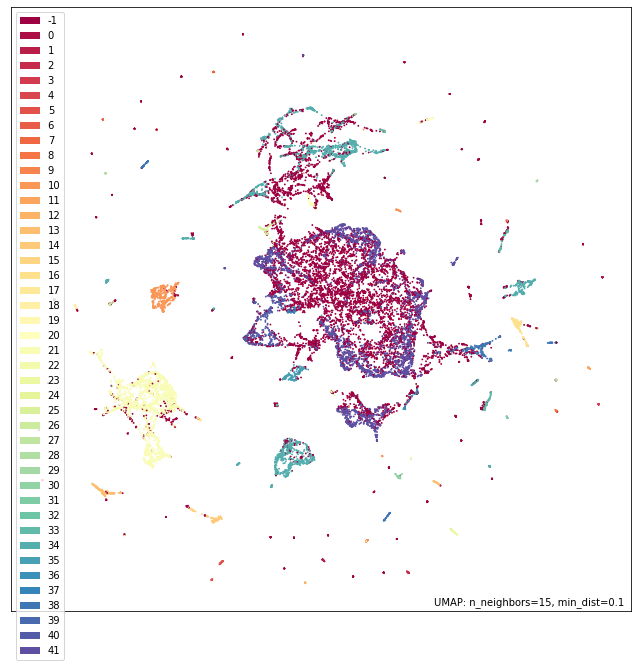

In [ ]:
umap.plot.points(mapper, labels=labels)

In [ ]:
post_ids, chunk_nums = [], []
for batch in ds:
  post_ids.append(batch["post_id"])
  chunk_nums.append(batch["chunk_num"])

post_ids = np.concatenate(post_ids)
post_ids = post_ids.astype(str)

chunk_nums = np.concatenate(chunk_nums)

In [ ]:
out_df = pd.DataFrame(
    {"post_id":post_ids, 
     "chunk_num":chunk_nums,
     "cluster":labels}
)

In [ ]:
UMAP_df = pd.DataFrame(Z, columns=[f"z{i}" for i in range(Z.shape[1])])
out_df = pd.concat([out_df, UMAP_df], axis=1)
out_df

,post_id,chunk_num,cluster,z0,z1,z2,z3,z4
0,lc7aj4,0,-1,11.520249,10.176333,10.322124,-0.283960,9.739444
1,l8q7yg,0,-1,11.060429,9.986012,9.873450,-0.197139,10.654449
2,l70zah,0,-1,11.421103,9.091762,11.081760,-0.059767,7.914190
3,l71n3m,0,-1,10.935250,10.059787,10.542604,1.500129,9.251620
4,l6wyy7,0,-1,10.736950,10.322493,9.951429,1.937703,8.488021
...,...,...,...,...,...,...,...,...
20689,lb331a,1,33,10.763622,9.080826,10.619658,0.086485,8.231236
20690,l7k3ee,0,-1,10.298615,10.073264,11.028797,0.487953,9.372173
20691,lbnrmi,1,27,12.085300,10.892224,9.407834,1.007127,10.403769
20692,l7bbkc,0,33,11.431671,8.941111,10.800887,0.851950,7.985167


In [ ]:
CSV_OUTPUT_PATH = str(NP_SINK_DIR/
                        ("HDBSCAN_clustered_{timestamp}_dim={d}"\
                         "_min_cl_size={m}_ep={epsilon}.csv"))
CSV_OUTPUT_PATH = CSV_OUTPUT_PATH.format(timestamp=timestamp, 
                                         d=d, 
                                         m=m, 
                                         epsilon=epsilon)

out_df.to_csv(CSV_OUTPUT_PATH, index=False)

# Scratch

## Inspect results

In [ ]:
timestamp = "2021-03-06_17:01:11"
# print(f"Current timestamp is {timestamp}.")
NP_SINK_DIR = PROCESSED_DATA_DIR/timestamp
NP_SINK_DIR

PosixPath('/content/drive/My Drive/WSB-posts/data/sentences_2021-03-07_12:45:54/2021-03-06_17:01:11')

In [ ]:
HDBSCAN_LABEL_PATH = str(NP_SINK_DIR/"HDBSCAN_labels_02"/
                        "HDBSCAN_labels_{timestamp}_dim={d}_min_cl_size={m}.npy")
(d, m) = (14, 30)
l = np.load(HDBSCAN_LABEL_PATH.format(timestamp=timestamp,
                                      d=str(d).zfill(3),
                                      m=str(m).zfill(3)))
print(f"(d,m)={(d,m)}")
pd.Series(l).value_counts()

(d,m)=(14, 30)


 4    28841
-1     2867
 3       96
 0       78
 5       48
 2       37
 1       33
dtype: int64


## TPUs
Seems like more trouble than it's worth at the moment to run this on TPU's. Recording my progress here.

In [ ]:
# TPU's need data in GCS bucket. 
# Import this to have access to gsutil.

from google.colab import auth
auth.authenticate_user()

# this is from an official TPU tutorial notebook
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
raise BaseException("""ERROR: Not connected to a TPU runtime.""")

# can find path with `! gsutil ls ...`
DATA_PATH = "gs://dataset-for-colab-tpu/wsb-sentences-1.csv"

# A workaround to allow to use HUB modules on TPU's,  to avoid the issue
# that TPU's only access GCS buckets and not local storage.
os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "UNCOMPRESSED"


# this seems to put the models on the device
with tpu_strategy.scope():
  preprocessor = hub.KerasLayer(
      "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
  encoder = hub.KerasLayer(
      "https://tfhub.dev/google/universal-sentence-encoder-cmlm/en-base/1")
  
# I leave off with errors like
"""InvalidArgumentError: assertion failed: [Trying to access a placeholder that 
is not supposed to be executed. This means you are executing a graph generated 
from the cross-replica context in an in-replica context.]
	 [[{{node keras_layer_1/StatefulPartitionedCall/Assert/Assert}}]]"""
# Need to involve distribution strategy or AUTOTUNE in some way?
